<a href="https://colab.research.google.com/github/ANDUYONG/TitanicSurvivorPrediction/blob/main/Titanic_Numpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 타이타닉 데이터 셋 로드

# Seaborn에서 예시 데이터셋을 로드
df = sns.load_dataset('titanic')

In [3]:
df.drop(columns=['adult_male', 'deck', 'embark_town', 'alive', 'alone'], inplace=True)

# age 칼럼의 중앙값 계산 및 결측치 채우기
age_median = df['age'].median()
df['age'].fillna(age_median, inplace=True)

# embarked 칼럼의 최빈값 계산 및 결측치 채우기
embarked_mode = df['embarked'].mode()[0]
df['embarked'].fillna(embarked_mode, inplace=True)

# map 함수를 이용한 레이블 인코딩
df['sex'] = df['sex'].map({'male': 0, 'female': 1})
# embarked 칼럼 원-핫 인코딩
df = pd.get_dummies(df, columns=['embarked'], drop_first=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   survived    891 non-null    int64   
 1   pclass      891 non-null    int64   
 2   sex         891 non-null    int64   
 3   age         891 non-null    float64 
 4   sibsp       891 non-null    int64   
 5   parch       891 non-null    int64   
 6   fare        891 non-null    float64 
 7   class       891 non-null    category
 8   who         891 non-null    object  
 9   embarked_Q  891 non-null    bool    
 10  embarked_S  891 non-null    bool    
dtypes: bool(2), category(1), float64(2), int64(5), object(1)
memory usage: 58.6+ KB


/tmp/ipython-input-4014073675.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['age'].fillna(age_median, inplace=True)
/tmp/ipython-input-4014073675.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'd

In [4]:
# 논리 1 : 가족의 크기 ( 가족의 수에 따라 생존에 큰 영향을 미침 )
# 'sibsp'와 'parch'를 더하고 자신을 포함하기 위해 1을 더합니다.
df['FamilySize'] = df['sibsp'] + df['parch'] + 1

# 논리 2 : 단독 탑승 여부 ( 혼자 여행하는 승객은 생존률이 낮다는 가설 검증 )
# FamilySize가 1이면(혼자 탑승) 1, 아니면 0을 부여
df['IsAlone'] = np.where(df['FamilySize'] == 1, 1, 0)

# 특징 공학으로 대체된 칼럼들을 정리 > 복잡도 낮춤
df = df.drop(columns=['sibsp', 'parch'])

# Target (Y)
Y = df['survived']

# Features (X) - 타겟 칼럼과 스케일링에 부적합한 비숫자형/중복 칼럼 제거
X = df.drop(columns=['survived', 'class', 'who'])


In [5]:
from sklearn.preprocessing import StandardScaler

# StandardScaler 객체 생성
scaler = StandardScaler()

# X 데이터에 대해 학습(fit)하고 변환(transform) 적용
# X_scaled는 NumPy 배열이 됩니다.
X_scaled = scaler.fit_transform(X)

# 다시 Pandas DataFrame으로 변환하여 칼럼 이름 유지 (선택 사항이지만 권장)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

X_scaled.head()

,pclass,sex,age,fare,embarked_Q,embarked_S,FamilySize,IsAlone
0,0.827377,-0.737695,-0.565736,-0.502445,-0.307562,0.615838,0.059160,-1.231645
1,-1.566107,1.355574,0.663861,0.786845,-0.307562,-1.623803,0.059160,-1.231645
2,0.827377,1.355574,-0.258337,-0.488854,-0.307562,0.615838,-0.560975,0.811922
3,-1.566107,1.355574,0.433312,0.420730,-0.307562,0.615838,0.059160,-1.231645
4,0.827377,-0.737695,0.433312,-0.486337,-0.307562,0.615838,-0.560975,0.811922


In [6]:
from sklearn.model_selection import train_test_split

# X: 스케일링된 특징 데이터, Y: 타겟 데이터
# test_size=0.3: 전체 데이터 중 30%를 테스트 데이터로 사용
# random_state=42: 매번 동일한 결과를 얻기 위한 난수 시드 고정
# stratify=Y: Y(생존 여부)의 비율을 학습 세트와 테스트 세트에 동일하게 분배 (편향 방지)
X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, Y, test_size=0.3, random_state=42, stratify=Y
)

print(f"총 학습 데이터 수: {len(X_train)}")
print(f"총 테스트 데이터 수: {len(X_test)}")

총 학습 데이터 수: 623
총 테스트 데이터 수: 268


In [8]:
def sigmoid(z):
  # 시그모이드 활성화 함수
  # exp(-z) 값이 너무 클 때 오버플로우 방지
  return 1 / (1 + np.exp(-z))

def compute_loss(Y, P):
  N = len(Y)
  # log(P)가 0에 가까워지는 것을 방지하기 위해 작은 값(1e-15)를 더함
  P = np.clip(P, 1e-15, 1 - 1e-15)
  loss = -np.mean(Y * np.log(P) + (1 - Y) * np.log(1 - P))
  return loss

In [9]:
def logistic_regression(X_train, Y_train, learning_rate=0.01, epochs=1000):
  """
  NumPy를 이용한 로지스틱 회귀 학습 함수 (Batch Gradient Descent)

  X_train: (N, D) 형태의 Feature 행렬 (D는 Feature 개수)
  Y_train: (N,) 형태의 Target 벡터
  learning_rate: 학습률 (기본값: 0.01)
  epochs: 학습 반복 횟수 (기본값: 1000)
  """

  # 1. 초기 W, b 값 초기화
  N, D = X_train.shape # N: 데이터 개수, D: Feature 개수

  # W를 표준 정규 분포에서 작은 무작위 값으로 초기화 (D개)
  W = np.random.randn(D) * 0.01
  # b를 0으로 초기화 (단일 값)
  b = 0


  # 학습 기록을 저장할 리스트
  loss_history = []

  print(f"--- 학습 시작 (Feature 수: {D}, 데이터 수: {N}) ---")

  # 2. 학습 루프 시작
  for epoch in range(epochs):
    # 1) 선형 점수 구하기 : (W^T * X) + b
    Z = X_train @ W + b
    # 2) 예측 확률 구하기
    P = sigmoid(Z)

    # 3) 손실 계산
    current_loss = compute_loss(Y_train, P)
    loss_history.append(current_loss)

    # 역전파, 기울기 계산
    # 4) 오차 계산
    E = P - Y_train

    # 5) 기울기 dL_dW 계산 (X.T @ E / N)
    dL_dW = (X_train.T @ E) / N

    # 6) b의 기울기 dL_db 계산 (E의 평균)
    dL_db = np.mean(E)

    # 가중치, 편향 업데이트 (경사 하강법)
    W = W - learning_rate * dL_dW
    b = b - learning_rate * dL_db

    # print(f"{epoch} W: {W}")
    # print(f"{epoch} b: {b}")

    # 진행 상황 출력
    if (epoch + 1) % (epochs // 10) == 0:
      print(f"Epoch {epoch + 1}/{epochs} - Loss: {current_loss: .4f}")

  print("--- 학습 완료 ---")
  return W, b, loss_history


In [10]:
# --- 학습 실행 ---

# X_train을 2차원 배열로 변환 (W를 1차원으로 유지하기 위해)
# 기본적으로 DataFrame이 2차원 데이터임.
X_train_2d = X_train
row, column = X_train.shape

print(row)

# 학습률(보폭)과 에포크(반복 횟수) 설정
W_final, b_final, loss_history = logistic_regression(
    X_train_2d, Y_train, learning_rate=0.01, epochs=row
)

print("-" * 30)
print("### Test1 ###")
print("최종적으로 학습된 값:")
print(f"W: {W_final}")
print(f"b: {b_final}")
print("-" * 30)

623
--- 학습 시작 (Feature 수: 8, 데이터 수: 623) ---
Epoch 62/623 - Loss:  0.6196
Epoch 124/623 - Loss:  0.5729
Epoch 186/623 - Loss:  0.5420
Epoch 248/623 - Loss:  0.5205
Epoch 310/623 - Loss:  0.5048
Epoch 372/623 - Loss:  0.4931
Epoch 434/623 - Loss:  0.4840
Epoch 496/623 - Loss:  0.4769
Epoch 558/623 - Loss:  0.4711
Epoch 620/623 - Loss:  0.4665
--- 학습 완료 ---
------------------------------
### Test1 ###
최종적으로 학습된 값:
W: pclass       -0.453270
sex           0.797605
age          -0.201940
fare          0.247030
embarked_Q    0.038237
embarked_S   -0.155337
FamilySize   -0.089134
IsAlone      -0.143948
dtype: float64
b: -0.3718340265385902
------------------------------


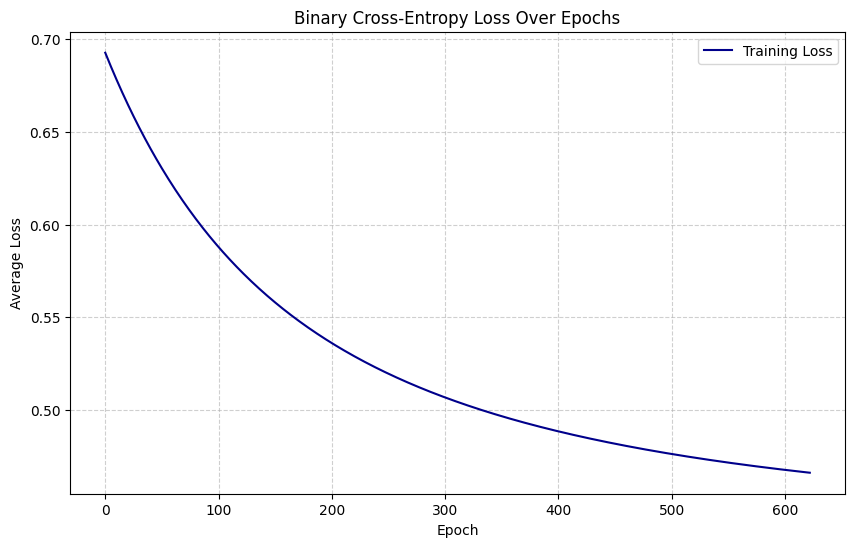

In [11]:
# --- 학습 결과 시각화 ---
plt.figure(figsize=(10, 6))
plt.plot(loss_history, label='Training Loss', color='darkblue')
plt.title('Binary Cross-Entropy Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

In [12]:
# --- 정확도 계산 ---
def predict(X, W, b):
  """ 학습된 W, b로 예측 수행"""
  Z = X @ W + b
  P = sigmoid(Z)
  return (P >= 0.5).astype(int)

In [13]:
# 테스트 데이터로 예측
Y_pred = predict(X_test, W_final, b_final)
accuracy = np.mean(Y_pred == Y_test)
print(f"테스트 데이터 정확도 (Accuracy): {accuracy * 100: .2f}%")

테스트 데이터 정확도 (Accuracy):  77.24%
